In [1]:
import os
import random

import numpy as np
import pandas as pd
import scipy as sc
from scipy.io import wavfile
from scipy import signal
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import Compose

import tensorboardX
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
out_f = open('log.txt', 'w')
TBoard = tensorboardX.SummaryWriter(log_dir='/media/storage8tb/logs/LearnablePINs/')

In [3]:
class AudioFrameDataset(Dataset):

    def __init__(self, path_to_data, path_to_split, phase, transform=None, seed=14): 
        self.path_to_data = path_to_data
        voice_set_labels = pd.read_table(path_to_split, sep=' ', names=['path', 'phase'])
        voice_set_labels.replace({'_000': '/0', '.wav$': ''}, inplace=True, regex=True)
        
        if phase == 1:
            mask = (voice_set_labels.phase == 1) | (voice_set_labels.phase == 3)
            dataset = voice_set_labels[mask].reset_index(drop=True)

        else:
            mask = voice_set_labels['phase'] == phase
            dataset = voice_set_labels[mask].reset_index(drop=True)
            
        self.dataset = dataset['path']
        self.transform = transform
        self.seed = np.random.RandomState(seed)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        ### VISUAL INPUT
        video_path = os.path.join(self.path_to_data, 'video', self.dataset[idx] + '.txt')
        frames = pd.read_table(video_path, skiprows=6, usecols=['FRAME '])        
        earliest = frames['FRAME '].iloc[0]
        latest = frames['FRAME '].iloc[-1]
        frame_list = np.arange(earliest, latest+1)
        mask = np.where(frame_list % 25 == 0)
        # only 20 per each face-track (see the asterics on the project page)
        # frames_sec = frame_list[mask]
        frames_sec = frame_list[mask][:20]
        selected_frame = self.seed.choice(frames_sec)
        selected_frame_filename = '{0:07d}.jpg'.format(selected_frame)
        selected_frame_path = os.path.join(self.path_to_data, 'video', 
                                           self.dataset[idx][:-5] + selected_frame_filename)
        out_f.write(selected_frame_path + '\n')
        frame = cv2.cvtColor(cv2.imread(selected_frame_path), cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_CUBIC)
        
        ### AUDIO INPUT
        segment_len = 3
        # not 1024 as reported in the referenced paper [35] 
        # because it gives 513xN but not 512xN
        FFT_len = 1022
        window = 'hamming'
        audio_path = os.path.join(self.path_to_data, 'audio', self.dataset[idx] + '.wav')
        out_f.write(audio_path + '\n')
        sample_rate, samples = wavfile.read(audio_path)
        window_width = int(sample_rate * 0.025)
        overlap = int(sample_rate * (0.025 - 0.010))
        start = len(samples) - segment_len * sample_rate
        end = start + segment_len * sample_rate
        audio_segment = samples[start:end]
        # Note, it produces 512x298 and I don't know why there is some subtle
        # differences. However, since the model averages second axis it doesn't
        # matter from computational POV.
        _, _, spectrogram = signal.spectrogram(audio_segment, sample_rate, 
                                               window=window, nfft=FFT_len, 
                                               nperseg=window_width, noverlap=overlap)
#         log_spectogram = np.log(spectrogram)
        log_spectogram = spectrogram.copy()
        assert sample_rate == 16000
        assert len(samples) >= sample_rate * segment_len
        
#         out_f.write(np.array_str(frame) + '\n')
#         out_f.write(np.array_str(log_spectogram) + '\n')
        
        if self.transform:
            frame = frame.astype(np.float32)
            log_spectogram = log_spectogram.astype(np.float32)
            frame, log_spectogram = self.transform((frame, log_spectogram))
        
        return (frame, log_spectogram)

In [4]:
class Normalize(object):
    """Normalizes both face (mean) and voice spectogram (mean-varience)"""
    
    def __call__(self, sample):
        frame, log_spectogram = sample

        ## FACE (H, W, C)
        # mean normalization for every image (not batch)
        mu = frame.mean(axis=(0, 1))
        frame = frame - mu
        
        ## VOICE (Freq, Time)
        # mean-variance normalization for every spectogram (not batch)
        mu = log_spectogram.mean(axis=1).reshape(512, 1)
        sigma = log_spectogram.std(axis=1).reshape(512, 1)
        log_spectogram = (log_spectogram - mu) / sigma

        return frame, log_spectogram

class RandomHorizontalFlip(object):
    '''Horizontally flip the given Image ndarray randomly with a given probability.'''
    
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        frame, log_spectogram = sample

        if random.random() < self.p:
            return cv2.flip(frame, 1), log_spectogram
        
        return frame, log_spectogram
    
### TODO saturation and brightness
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        frame, log_spectogram = sample
        F, T = log_spectogram.shape

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        frame = frame.transpose((2, 0, 1))
        
        # now log_specs are of size (Freq, Time) 2D but has to be 3D
        log_spectogram = log_spectogram.reshape(1, F, T)

        return torch.from_numpy(frame), torch.from_numpy(log_spectogram)

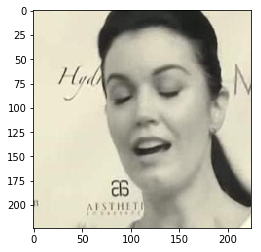

In [5]:
plt.figure()
img = cv2.imread('/media/storage8tb/data/voxceleb1/video/Bellamy_Young/vZY1f9oeIbo/0001375.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
# img = cv2.flip(img, 1)
plt.imshow(img)
plt.show()

In [6]:
## TRY TO ADD DROPOUT

class FaceSubnet(nn.Module):

    def __init__(self, seed=13):
        super(FaceSubnet, self).__init__()
#         torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        
        self.fc6 = nn.Linear(in_features=256 * 7 * 7, out_features=4096)
        self.fc7 = nn.Linear(in_features=4096, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=256)
        
        self.mpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        B, C, H, W = x.size()
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.mpool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.mpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        
        return F.normalize(x)

## TRY TO REMOVE DROPOUT

class VoiceSubnet(nn.Module):

    def __init__(self, seed=13):
        super(VoiceSubnet, self).__init__()
#         torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=7, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        
        self.bn6 = nn.BatchNorm2d(num_features=4096)
        
        self.fc7 = nn.Linear(in_features=4096, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=256)
        
        self.relu = nn.ReLU()
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool5 = nn.MaxPool2d(kernel_size=(5, 3), stride=(3, 2))
        
        # Conv2d with weights of size (H, 1) is identical to FC with H weights
        self.fc6 = nn.Conv2d(in_channels=256, out_channels=4096, kernel_size=(9, 1))
        
    def forward(self, x):
        B, C, H, W = x.size()

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.mpool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.mpool5(x)

        B, C, H, W = x.size()
        self.apool6 = nn.AvgPool2d(kernel_size=(1, W))

        x = self.relu(self.bn6(self.fc6(x)))
        x = self.apool6(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        
        return F.normalize(x)

class CurriculumMining(nn.Module):

    def __init__(self):
        super(CurriculumMining, self).__init__()
        
    def forward(self, positive_pairs, tau):
        faces, voices = positive_pairs
        B, D = faces.size()
        # calc dist 
        # (X - Y) ^ 2 = X^2 + Y^2 - 2XY
        x = (faces**2).sum(dim=1).view(-1, 1) + (voices**2).sum(dim=1) - 2*faces.matmul(voices.t())
        dists = x.sqrt()
        
        sorted_dist, sorted_idx = torch.sort(dists, dim=1, descending=True)
        Dnj = sorted_dist - dists.diag().view(-1, 1)
        idx_threshold = round(tau * (B-1))
        
        # tricky part
        mask = torch.ones_like(sorted_dist)
        mask[:, idx_threshold+1:] = 0
        mask[Dnj <= 0] = 0
        idx_of_sorted_idx = ((mask).sum(dim=1) - 1).abs().long()
        neg_samples_idx = torch.gather(sorted_idx, dim=1, index=idx_of_sorted_idx.view(B, 1))
        neg_samples_idx = neg_samples_idx.view(B)
        negative_voices = voices[neg_samples_idx]
        
        return (faces, negative_voices)

class ContrastiveLoss(nn.Module):

    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        
    def forward(self, positive_pairs, negative_pairs, margin):
        ## POSITIVE PART
        faces, voices = positive_pairs
#         dists_pos = ((faces - voices) ** 2).sum(dim=1).sqrt()
#         pos_part = dists_pos ** 2
        pos_part = ((faces - voices) ** 2).sum(dim=1)
    
        ## NEGATIVE PART
        faces, voices = negative_pairs
        dists_neg = ((faces - voices) ** 2).sum(dim=1).sqrt()
        neg_part = (margin - dists_neg).clamp(0) ** 2
        
        loss4pair = torch.cat([pos_part, neg_part])
        
        ## CALCULATE LOSS
        B, D = faces.size()
        batch_loss = loss4pair.sum() / (2 * B)
        
        return batch_loss

class LearnablePinsNet(nn.Module):

    def __init__(self):
        super(LearnablePinsNet, self).__init__()
        self.face_subnet = FaceSubnet()
        self.voice_subnet = VoiceSubnet()
        self.curr_mining = CurriculumMining()
        
    def forward(self, frames, log_specs, tau):
        emb_f = self.face_subnet(frames)
        emb_v = self.voice_subnet(log_specs)
        
        positive_pairs = (emb_f, emb_v)
        negative_pairs = self.curr_mining(positive_pairs, tau)
        
        return positive_pairs, negative_pairs

In [7]:
assert False == True

AssertionError: 

In [ ]:
transform = Compose([
    Normalize(),
#     RandomHorizontalFlip(),
    ToTensor(),
])

train = AudioFrameDataset('/media/storage8tb/data/voxceleb1/', 
                          '/media/storage8tb/data/voxceleb1/Splits/voice_set_labels.txt', 
                          phase=1, transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=2, num_workers=0)

net = LearnablePinsNet()

criterion = ContrastiveLoss()
# inpaper lr = 1e-2
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10 ** (-3/25))

device = torch.device("cuda:0")
# net = nn.DataParallel(net, device_ids=[0, 1])

net.to(device)

for epoch_num in range(50):
    net.train()
    scheduler.step()
    
    for iter_num, (frames, log_specs) in tqdm(enumerate(trainloader)):
        out_f.write('{}-{}\n'.format(str(epoch_num), str(iter_num)))
        # transfer inputs to a device
        frames, log_specs = frames.to(device), log_specs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # tau: todo: 0.3 -> 0.8
        positive_pairs, negative_pairs = net(frames, log_specs, tau=0.3)
        loss = criterion(positive_pairs, negative_pairs, margin=0.6)

        loss.backward()
        optimizer.step()

        # log results
        step_num = epoch_num * len(trainloader) + iter_num
        TBoard.add_scalar('Train/Loss', loss.item(), step_num)
        TBoard.add_scalar('Train/lr', scheduler.get_lr()[0], step_num)
        TBoard.add_scalar('emb_mean/face', positive_pairs[0].mean(), step_num)
        TBoard.add_scalar('emb_mean/voice', positive_pairs[1].mean(), step_num)
        TBoard.add_scalar('weights/voice_conv1', net.voice_subnet.conv1.weight.mean(), step_num)
        
        out_f.write('\n\n'.format(str(epoch_num), str(iter_num)))

In [ ]:
net.voice_subnet.conv1.weight

In [ ]:
np.array2string(np.arange(3))

In [ ]:
out_f.close()

In [ ]:
tau = 1
# B = 5
# D = 2
# torch.manual_seed(2)
# emb_f = torch.randint(0, 50, (B, D))
# emb_v = torch.randint(0, 50, (B, D))
print(emb_v.shape, emb_f.shape)
print(emb_f)
print(emb_v)

In [ ]:
margin = 40

faces, voices = positive_pairs
dists_pos = ((faces - voices) ** 2).sum(dim=1).sqrt()
print(dists_pos)
pos_part = dists_pos ** 2
pos_part = ((faces - voices) ** 2).sum(dim=1)


faces, voices = negative_pairs
dists_neg = ((faces - voices) ** 2).sum(dim=1).sqrt()
print(dists_neg)

pos_part = dists_pos ** 2
neg_part = (margin - dists_neg).clamp(0) ** 2
print(neg_part)

print(pos_part, neg_part)

loss4pair = torch.cat([pos_part, neg_part])
print(loss4pair)

loss = loss4pair.sum() / (2*B)
print(loss)

In [ ]:
import scipy.io
mat = scipy.io.loadmat('emovoxceleb-student.mat')

In [ ]:
print(mat['net'][0][0][1][0][5][1].shape)
print(mat['net'][0][0][1][0][5])

In [ ]:
path_to_data = '/media/storage8tb/data/voxceleb1/'
path_to_split = '/media/storage8tb/data/voxceleb1/Splits/voice_set_labels.txt'
phase = 1
voice_set_labels = pd.read_table(path_to_split, sep=' ', names=['path', 'phase'])
voice_set_labels.replace({'_000': '/0', '.wav': ''}, inplace=True, regex=True)
print(voice_set_labels['phase'].value_counts())
print(voice_set_labels.shape)
voice_set_labels.head(6)

In [ ]:
if phase == 1:
    mask = (voice_set_labels.phase == 1) | (voice_set_labels.phase == 3)
    subset = voice_set_labels[mask].reset_index(drop=True)
    
else:
    mask = voice_set_labels['phase'] == phase
    subset = voice_set_labels[mask].reset_index(drop=True)
    
print(subset['phase'].value_counts())
subset = subset['path']
print(subset.shape)
print()
print(subset[2])
subset.head(6)

In [ ]:
path_to_data = '/media/storage8tb/data/voxceleb1/'
path_to_split = '/media/storage8tb/data/voxceleb1/Splits/voice_set_labels.txt'
# video_path = os.path.join(path_to_data, 'video', 'Ben_Feldman', 'FWkA8o6AwB0', , '.txt')
audio_path = os.path.join(path_to_data, 'audio', 'Ben_Feldman', 'FWkA8o6AwB0', '00002.wav')

sample_rate, samples = wavfile.read(audio_path)
frequencies, times, spectrogram = signal.spectrogram(samples[:48000], sample_rate, window='hamming', 
                                                     nfft=1022, nperseg=int(sample_rate * 0.025), 
                                                     noverlap=int(sample_rate * (0.025-0.010)), mode='magnitude')

plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, np.log(spectrogram), cmap=plt.cm.jet)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
print(np.log(spectrogram).shape)
plt.show()

In [ ]:
spectrogram2.shape

In [ ]:
spectrogram.shape

In [ ]:
import librosa

In [ ]:
librosa.feature.melspectrogram()

In [ ]:
spectrogram

In [ ]:
segment_len = 3
sample_rate = 16000
len(samples)

In [ ]:
# start = rand_generator.randint(0, len(samples) - segment_len * sample_rate)
start = len(samples) - segment_len * sample_rate
end = start + segment_len * sample_rate
audio_segment = samples[start:end]
print(audio_segment.shape)
print(start, end)
print(audio_segment[-1])

In [ ]:
# TODO: make all number of proper length to insert to path

In [ ]:
### 
video_path = os.path.join(path_to_data, 'video', subset[3] + '.txt')
frames = pd.read_table(video_path, skiprows=6, usecols=['FRAME '])
earliest = frames['FRAME '].iloc[0]
latest = frames['FRAME '].iloc[-1]
frame_list = np.arange(earliest, latest+1)
mask = np.where(frame_list % 25 == 0)
frames_sec = frame_list[mask]
print(frames_sec)
rand_generator = np.random.RandomState(13)
selected_frame = rand_generator.choice(frames_sec)
print(selected_frame)
selected_frame_filename = '{0:07d}.jpg'.format(selected_frame)
selected_frame_path = os.path.join(path_to_data, 'video', subset[2][:-5] + selected_frame_filename)
print(selected_frame_filename)
print(selected_frame_path)
frame = cv2.cvtColor(cv2.imread(selected_frame_path), cv2.COLOR_BGR2RGB)
frame = cv2.resize(frame, (224, 224))
plt.figure()
plt.imshow(frame);

In [ ]:
import cv2
from skimage.io import imread
import dlib
import imutils

In [ ]:
some_path = '/media/storage8tb/data/voxceleb1/video/A.J._Buckley/J9lHsKG98U8/'
files = os.listdir(some_path)
files = [os.path.join(some_path, x) for x in files if x[-3:] == 'jpg']

In [ ]:
%%timeit

for file in files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

In [ ]:
plt.figure()
img = cv2.imread('/media/storage8tb/data/voxceleb1/video/A.J._Buckley/1zcIwhmdeo4/0000375.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [ ]:
img234 = dlib.load_rgb_image(files[-1])
img123 = cv2.imread(files[-1])
img123 = cv2.cvtColor(img123, cv2.COLOR_BGR2RGB)

In [ ]:
img234 = dlib.load_rgb_image(files[-1])
img234 = dlib.resize_image(img234, rows=224, cols=224)
img123 = cv2.imread(files[-1])
img123 = cv2.cvtColor(img123, cv2.COLOR_BGR2RGB)
img123 = cv2.resize(img123, (224, 224))

In [ ]:
img234 = cv2.imread(files[-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img, (224, 224))

img123 = dlib.load_rgb_image(files[-1])
img2 = dlib.resize_image(img, rows=224, cols=224)
# img123 - img234

In [ ]:
%%timeit

for file in files:
    img = imread(file)

In [ ]:
%%timeit

for file in files:
    img = dlib.load_rgb_image(file)
    img = dlib.resize_image(img, rows=224, cols=224)

In [ ]:
plt.figure()
plt.imshow(img234 - img123)
plt.show()

In [ ]:
plt.figure()
img = dlib.load_rgb_image(files[-12])
print(img.shape)
img = dlib.resize_image(img, rows=224, cols=224)
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
transform = Compose([
    Normalize(),
#     RandomHorizontalFlip(),
    ToTensor(),
])

dataset = AudioFrameDataset('/media/storage8tb/data/voxceleb1/', 
                          '/media/storage8tb/data/voxceleb1/Splits/voice_set_labels.txt', 
                          phase=1, transform=transform)
fig = plt.figure(figsize=(10, 10))

for i in range(len(dataset)):
    batch = dataset[i]
    
    ax = plt.subplot(4, 2, 2*i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    plt.imshow(batch[2])
    ax = plt.subplot(4, 2, 2*i + 2)
    plt.pcolormesh(batch[0], batch[1], batch[3], cmap=plt.cm.jet)
    
    if i == 3:
        plt.show()
        break
plt.show()

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

path_to_data = '/media/storage8tb/data/voxceleb1/'
path_to_split = '/media/storage8tb/data/voxceleb1/Splits/voice_set_labels.txt'

missing_segments_savepath = '/home/vladimir/Desktop/missing_segments.txt'
missing_frames_savepath = '/home/vladimir/Desktop/missing_frames.txt'
source2missing_frames_savepath = '/home/vladimir/Desktop/source2missing_frames.txt'

missing_segments = []
missing_frames = []
source2missing_frames = {}

voice_set_labels = pd.read_table(path_to_split, sep=' ', names=['path', 'phase'])
voice_set_labels.replace({'_000': '/0', '.wav$': ''}, inplace=True, regex=True)

for i, path in tqdm(enumerate(voice_set_labels['path'])):
    video_path = os.path.join(path_to_data, 'video', path + '.txt')
    
    if os.path.isfile(os.path.join(path_to_data, 'audio', path + '.wav')):
        frames = pd.read_table(video_path, skiprows=6, usecols=['FRAME '])
        
    else:
        print('segment is missing: {}'.format(video_path[39:]))
        missing_segments.append(video_path[39:])
        continue
    
    
    earliest = frames['FRAME '].iloc[0]
    latest = frames['FRAME '].iloc[-1]
    frame_list = np.arange(earliest, latest+1)
    mask = np.where(frame_list % 25 == 0)
    frames_sec = frame_list[mask]
    
    source2missing_frames[video_path[39:]] = []
    
    for frame_number in frames_sec:
        filename ='{0:07d}.jpg'.format(frame_number)
        selected_frame_path = os.path.join(path_to_data, 'video', path[:-5] + filename)
        
        if os.path.isfile(selected_frame_path):
            continue
            
        else:
            missing_frames.append(selected_frame_path[39:])
            source2missing_frames[video_path[39:]].append(selected_frame_path[39:])

with open(missing_frames_savepath, 'w') as out_f:
    for file in missing_frames:
        out_f.write(file + '\n')

with open(source2missing_frames_savepath, 'w') as out_f:
    out_f.write(json.dumps(source2missing_frames, indent='\t'))
    
with open(missing_segments_savepath, 'w') as out_f:
    for file in missing_segments:
        out_f.write(file + '\n')

In [ ]:
x = raw[0, :, :, 4]
a = fc6.weight[1, :, :, :]
b = fc6.bias[1]
print(x)
print(a)
print(b)
np.sum(a.detach().numpy().reshape(4, -1) * x.detach().numpy().reshape(4, -1)) + b.detach().numpy()

In [ ]:
## TODO WHAT IS GOING ON ON TEST TIME
B = 3
C = 2
H = 4
W = 5

raw = torch.randn(B, C, H, W)
# print(raw)
H, W = raw.size()[2:]
fc6 = nn.Conv2d(in_channels=C, out_channels=C, kernel_size=(H, 1))
# print(fc6.weight)
# print(fc6.bias)
temp = fc6(raw)
# print(temp.size())
# print(temp)
max_ = nn.MaxPool2d(kernel_size=(1, W))
temp = max_(temp)
# print(temp.size())
# print(temp)

First, let's create artificial subnets' outputs. We now assume that the $\tau = 1$ which means that we mine the hardest negatives for each anchor face in the batch. Also, we will use a batch of size B = 3 (in paper 256) and D = |emb| = 2 (in paper 256). We expect that tensors are of size BxD.

In [ ]:
torch.manual_seed(13)

tau = 1
B = 3
D = 2

emb_f = torch.randint(0, 50, (B, D))
emb_v = torch.randint(0, 50, (B, D))
print('face subnet output:')
print(emb_f)
print('voice subnet output:')
print(emb_v)

Then, we calculate distance between each face and voice embeddings

In [ ]:
# (X - Y) ^ 2 = X^2 + Y^2 - 2XY
x = (emb_f**2).sum(dim=1).view(-1, 1) + (emb_v**2).sum(dim=1) - 2*emb_f.matmul(emb_v.t())
dists = x.sqrt()
print(dists)

dists$_{i,j}$ -- distance between $i$-th element in face batch and $j$-th element in voice batch. In case $i=j$ (diagonal elements), the number corresponds to the distance between a positive pair embeddings.

Okay, given the distance matrix above let's guess which negative counterpart every anchor face should have for this $\tau$. 

For the first face (1st row) we have three options: [32.4500, 46.1736, 24.0208]. In this case, we may want to choose the 3rd element (24.0208) as it is the hardest (closest) one but we have the restriction (p. 7, top) that the distance of to a potential negative counterpart should be higher than the distance between the positive pair which is 32.4500. So, for the first face we choose the 2nd element (46.1736).

For the second face we have a similar situation. The hardest is the 3rd element (13.0000) but it is closer than the positive counterpart (24.1661). Hence, we choose the closest voice that is further than positive pair, i.e. 1st one (32.1403).

For the third face the closest voice is on the third position (1.0000) but it is just a positive counterpart. We cannot choose it. So, we will select the first voice (18.2483).

And obtain the following list of negative counterparts for each anchor face: 

Indices (starting with 0): [1, 0, 0]; Values:
[46.1736, 32.1403, 18.2483]

Now, let's proceed with the algorithm that you provided in Appendix. 

First, we sort the distance matrix. Note, the sorted matrix also contains the values when  $i=j$ , just keep it in mind.

In [ ]:
sorted_dist, sorted_idx = torch.sort(dists, 1, descending=True)
print(sorted_dist)
print(sorted_idx)

On this step, we select only indices of the hardest negatives ($\tau$ = 1). Therefore, we are interested in the last column excluding the indices that correspond to the positive pair ($i=j$) which occurs in the last row.

So, we have vector of indices: $(n_0, n_1, n_2) =$ [2, 2, 0]. 

Now, let's calculate 5th step in the algorithm.

In [ ]:
Dii = dists.diag().view(-1, 1)
(sorted_dist - Dii).abs()

After the $arg \min_j$ we obtain the following list of indices: [2, 0, 1]. Note, we excluded elements showing the positive pairs difference (0.0000) from the $\min$ function.

Finally, let's apply $\min$ function for each corresponding pair of [2, 2, 0] and [2, 0, 1]. We will obtain [2, 0, 0] but should have obtained [1, 0, 0] as shown above.

In [ ]:
tau = 1
B = 5
D = 2
torch.manual_seed(2)
emb_f = torch.randint(0, 50, (B, D))
emb_v = torch.randint(0, 50, (B, D))
print(emb_v.shape, emb_f.shape)
print(emb_f)
print(emb_v)

# (X - Y) ^ 2 = X^2 + Y^2 - 2XY
x = (emb_f**2).sum(dim=1).view(-1, 1) + (emb_v**2).sum(dim=1) - 2*emb_f.matmul(emb_v.t())
dists = x.sqrt()
print(dists)

sorted_dist, sorted_idx = torch.sort(dists, 1, descending=True)
print(sorted_dist)
print(sorted_idx)

idx_threshold = round(tau * (B-1))
idx_threshold

mask = torch.ones_like(sorted_dist)
print(mask)
mask[:, idx_threshold+1:] = 0
print(mask)

Dnj = sorted_dist - dists.diag().view(-1, 1)
mask[Dnj <= 0] = 0
print(Dnj)
print(mask)

idx_of_sorted_idx = ((mask).sum(dim=1) - 1).abs().long()
print(idx_of_sorted_idx)

neg_samples_idx = torch.gather(sorted_idx, dim=1, index=idx_of_sorted_idx.view(B, 1))
neg_samples_idx = neg_samples_idx.view(B)
print(neg_samples_idx)

emb_v[neg_samples_idx]

In [ ]:
B = 16
C = 3
H = 224
W = 224

frames = torch.randn(B, C, H, W)
emb_f = facesubnet(frames)

In [ ]:
B = 16
C = 1
H = 512
W = 298

log_specs = torch.randn(B, C, H, W)
emb_v = voicesubnet(log_specs)
print(emb_v.sum())

In [ ]:
raw.mean(axis=(1, 2)).reshape(2, 1, 1, 3)

In [ ]:
raw = np.arange(5*5*3).reshape(5, 5, 3)
print(raw[:, :, 0])
mu = raw.mean(axis=(0, 1))
a = raw - mu
print(a[:, :, ])

In [ ]:
class Normalize(object):
    """Normalizes both face (mean) and voice spectogram (mean-varience)"""
    
    def __call__(self, sample):
        frame, log_spectogram = sample
        
        ## FACE (H, W, C)
        # mean normalization for every image (not batch)
        mu = frame.mean(axis=(0, 1))
        frame = frame - mu
        
        ## VOICE (Freq, Time)
        # mean-variance normalization for every spectogram (not batch)
        mu = log_spectogram.mean(axis=1).reshape(512, 1, 1)
        sigma = log_spectogram.std(axis=1).reshape(512, 1, 1)
        log_spectogram = (log_spectogram - mu) / sigma
        return frame, log_spectogram
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        frame, log_spectogram = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        frame = frame.transpose((2, 0, 1))
        
        return torch.from_numpy(frame), torch.from_numpy(log_spectogram)

class ToPILImage(object):
    """Converts a torch.*Tensor of shape C x H x W 
    or a numpy ndarray of shape H x W x C 
    to a PIL Image while preserving the value range.
    """
    
    def __call__(self, sample):
        frame, log_spectogram = sample
        
        print(frame.dtype)
        log_spectogram = log_spectogram.reshape(512, -1, 1)
        
        frame = F_transform.to_pil_image(frame)
        log_spectogram = F_transform.to_pil_image(log_spectogram)
        
        return log_spectogram, frame